In [1]:
import numpy as np
import pandas as pd
import chart_studio.plotly
import plotly.express as px
import matplotlib.pyplot as plt
import warnings 

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn')

In [2]:
PATH = '/Users/dhyungseoklee/Projects/data/'
train_id = pd.read_csv(PATH + 'train_identity.csv')
train_trans = pd.read_csv(PATH + 'train_transaction.csv')
test_id = pd.read_csv(PATH + 'test_identity.csv')
test_trans = pd.read_csv(PATH + 'test_transaction.csv')

In [3]:
train = pd.merge(train_trans, train_id, on = 'TransactionID', how = 'left')
test = pd.merge(test_trans, train_id, on = 'TransactionID', how = 'left')

In [15]:
# explore null values
train_null = train.isnull().any().sum()
test_null = test.isnull().any().sum()
print(f''' columns with null values in train: {train_null}''')
print(f''' columns with null values in test: {test_null}''')

 columns with null values in train: 414
 columns with null values in test: 385


## Exploratory Analysis

 id_1 - id_11 are numerical features and id_12 - id_38 are categorical
 <br>
 exploring numerical features first

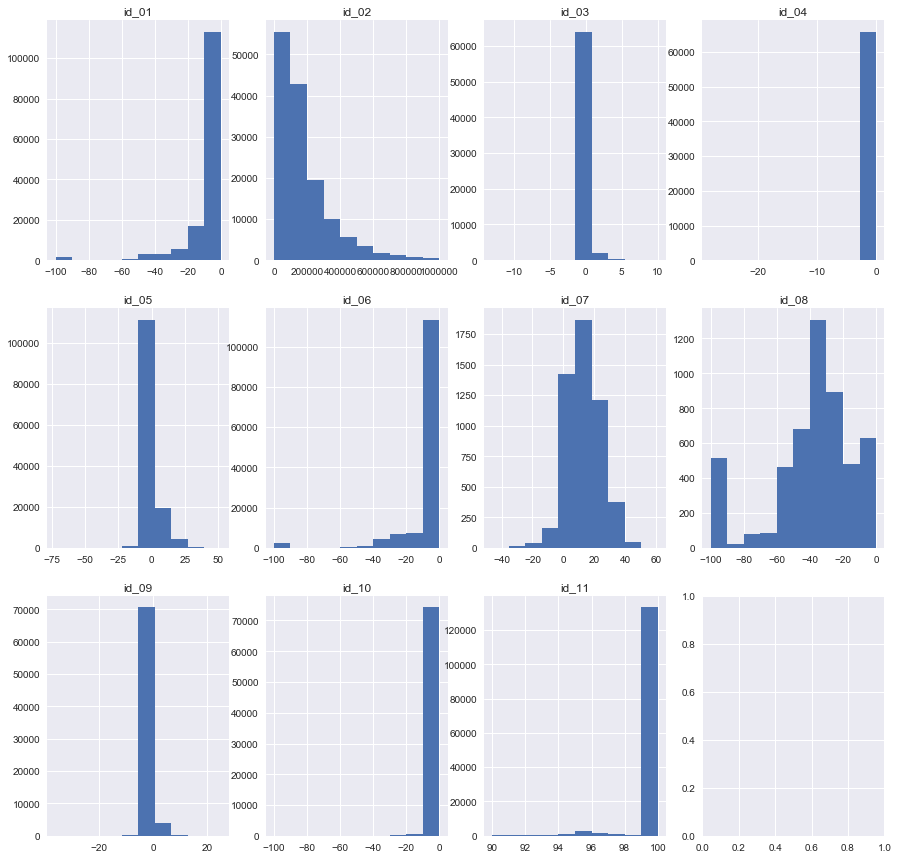

In [87]:
num_ids = train_id.ix[:,1:12]
fig, ax = plt.subplots(nrows = 3, ncols = 4, figsize =(15,15))
ax = ax.ravel()
for i, col in enumerate(num_ids):
    ax[i].hist(num_ids[col])
    ax[i].set_title(str(col))
plt.show()

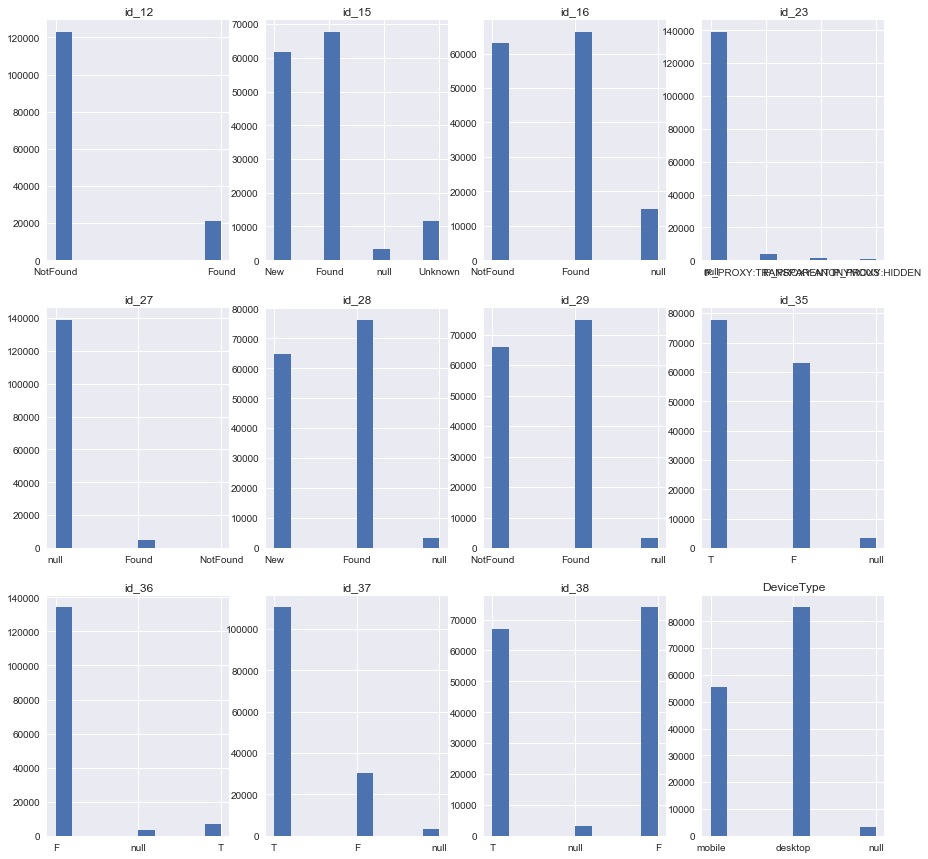

In [178]:
# now explore categorical variables
cat_ids = train_id.ix[:,12:41]
plot_cat = cat_ids[cat_ids.columns[cat_ids.dtypes == 'object']]
plot_cat = plot_cat[plot_cat.columns[plot_cat.nunique() < 4]]
plot_cat = plot_cat.fillna('null')
fig, ax = plt.subplots(nrows = 3, ncols = 4, figsize = (15,15))
ax = ax.ravel()

for i, col in enumerate(plot_cat):
    ax[i].hist(plot_cat[col])
    ax[i].set_title(str(col))
    plt.sca(ax[i])
    plt.xticks(rotation = 0)
    
plt.show()

In [185]:
# exploring other variables
cat_other = cat_ids[cat_ids.columns[cat_ids.dtypes == 'object']]
cat_other = cat_ids[cat_ids.columns[cat_ids.nunique() > 5]]
cat_other.head()

,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_30,id_31,id_33,DeviceInfo
0,NaN,-480.0,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,Android 7.0,samsung browser 6.2,2220x1080,SAMSUNG SM-G892A Build/NRD90M
1,49.0,-300.0,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,iOS 11.1.2,mobile safari 11.0,1334x750,iOS Device
2,52.0,NaN,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,chrome 62.0,NaN,Windows
3,52.0,NaN,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,chrome 62.0,NaN,NaN
4,NaN,-300.0,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,Mac OS X 10_11_6,chrome 62.0,1280x800,MacOS


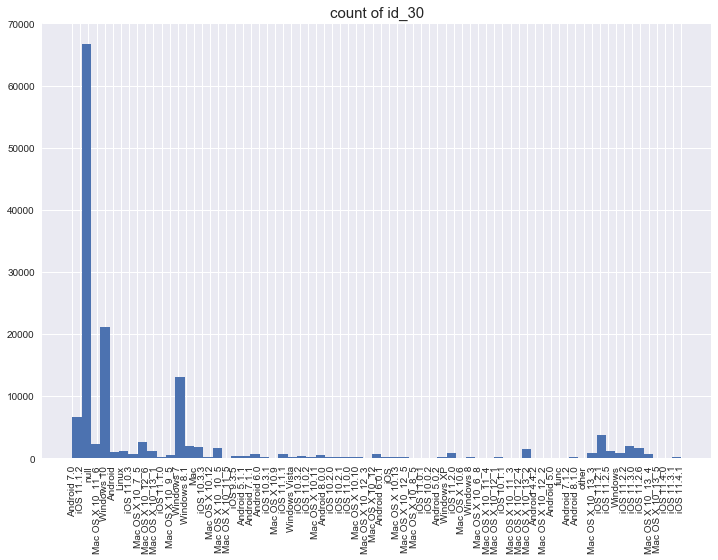

In [201]:
plt.figure(figsize = (12,8))
cat_other_plot = cat_other.fillna('null')
plt.hist(cat_other_plot['id_30'],bins = 65)
plt.xticks(rotation = 90)
plt.title('count of id_30', fontsize = 15)
plt.show()

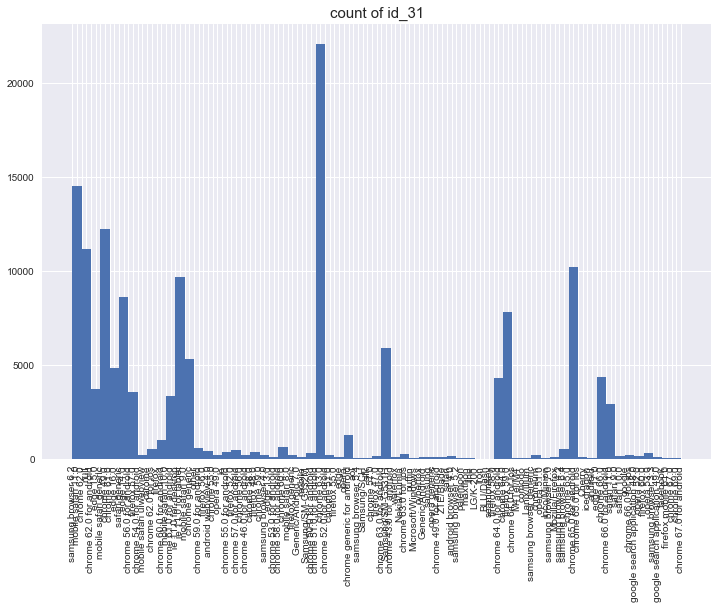

In [200]:
plt.figure(figsize = (12,8))
cat_other_plot = cat_other.fillna('null')
plt.hist(cat_other_plot['id_31'],bins = 65)
plt.xticks(rotation = 90)
plt.title('count of id_31', fontsize = 15)
plt.show()

Let's look at transaction data now

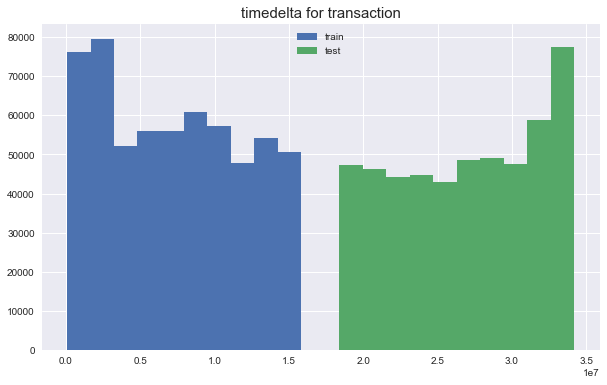

In [209]:
plt.figure(figsize = (10,6))
plt.hist(train_trans['TransactionDT'], label = 'train')
plt.hist(test_trans['TransactionDT'], label = 'test')
plt.legend()
plt.title('timedelta for transaction', fontsize = 15)
plt.show()

looks like train and test data don't overlap and has time gap in between

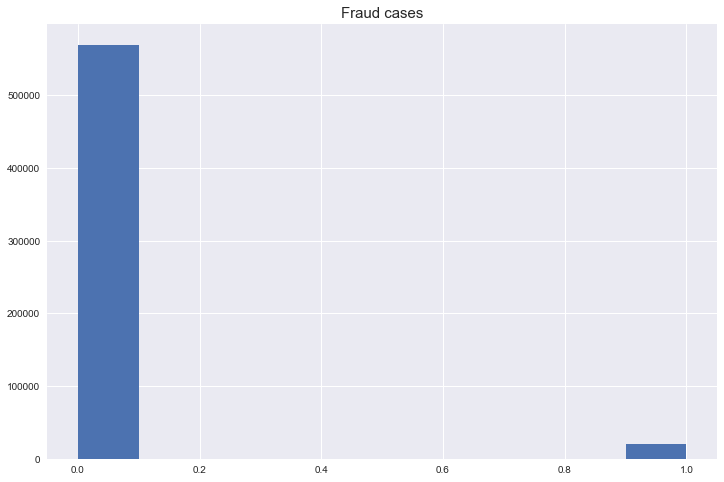

In [213]:
# exploring target variable
plt.figure(figsize = (12,8))
plt.hist(train_trans['isFraud'])
plt.title('Fraud cases', fontsize = 15)
plt.show()

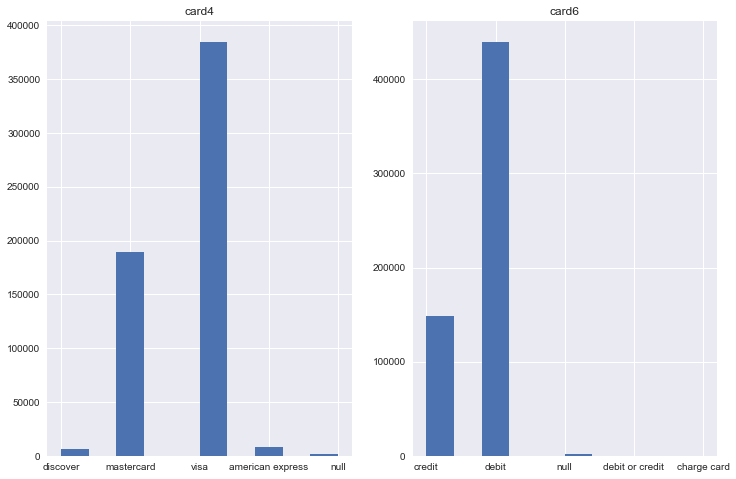

In [226]:
# payment card info
card_info = train_trans.ix[:,5:11]
card_info = card_info[card_info.columns[card_info.dtypes == 'object']]
card_info = card_info.fillna('null')
fig, ax = plt.subplots(1,2,figsize = (12,8))
ax = ax.ravel()
for i, col in enumerate(card_info):
    ax[i].hist(card_info[col])
    ax[i].set_title(col)
plt.show()

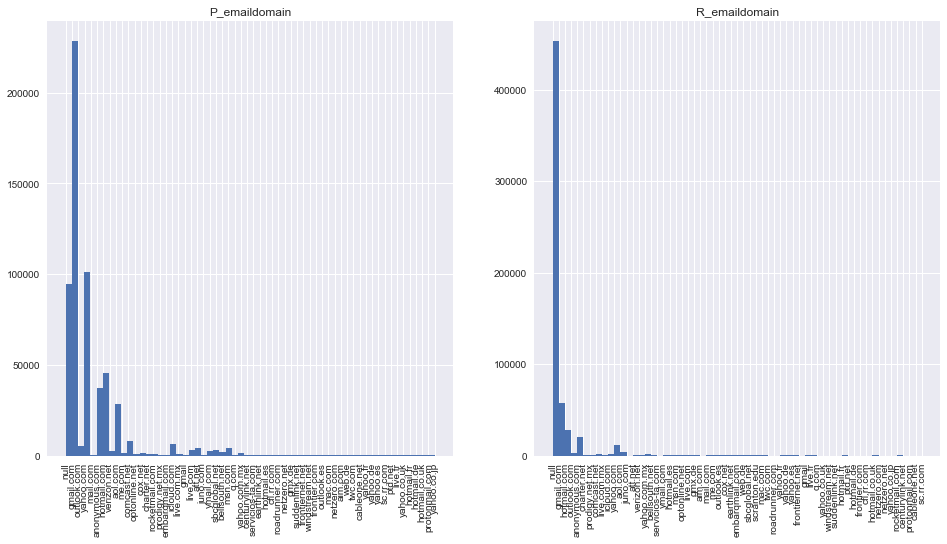

In [242]:
# explore more categorical features
email_cat = train_trans[['P_emaildomain', 'R_emaildomain']]
email_cat = email_cat.fillna('null')
fig, ax = plt.subplots(1,2,figsize = (16,8))
ax = ax.ravel()
for i, col in enumerate(email_cat):
    ax[i].hist(email_cat[col],bins = 60)
    ax[i].set_title(col)
    plt.sca(ax[i])
    plt.xticks(rotation = 90)
plt.show()

## Feature Engineering

feature engineering idea comes from [here](https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt)

In [4]:
train['Trans_min_mean'] = train['TransactionAmt'] - train['TransactionAmt'].mean()
train['Trans_min_std'] = train['Trans_min_mean'] / train['TransactionAmt'].std()
test['Trans_min_mean'] = test['TransactionAmt'] - test['TransactionAmt'].mean()
test['Trans_min_std'] = test['Trans_min_mean'] / test['TransactionAmt'].std()

In [5]:
train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('std')

test['TransactionAmt_to_mean_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_std_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('std')

In [6]:
# define some columns to drop
null_columns = [col for col in train.columns if train[col].isnull().sum()/train.shape[0] > 0.9]
null_columns_test = [col for col in test.columns if test[col].isnull().sum()/test.shape[0] > 0.9]

top_val_columns = [col for col in train.columns if train[col].value_counts(dropna=False,
                                                    normalize = True).values[0] > 0.9]
tol_val_columns_test = [col for col in test.columns if test[col].value_counts(dropna = False,
                                                    normalize = True).values[0] > 0.9]

one_val_column = [col for col in train.columns if train[col].value_counts().count == 1]
one_val_column_test = [col for col in test.columns if test[col].value_counts().count == 1]

In [7]:
columns_to_drop = list(set(null_columns + null_columns_test + top_val_columns + 
                           tol_val_columns_test + one_val_column + one_val_column_test))
columns_to_drop.remove('isFraud')
len(columns_to_drop)

112

In [8]:
# drop columns
train_new = train.drop(columns_to_drop, axis = 1)
test_new = test.drop(columns_to_drop, axis = 1)

In [9]:
target = train_new.sort_values('TransactionDT')['isFraud']
train_new = train_new.sort_values('TransactionDT').drop(columns = ['isFraud','TransactionDT'
                                                                   ,'TransactionID'], axis = 1)
test_new = test_new.sort_values('TransactionDT').drop(columns = ['TransactionDT','TransactionID'],
                                                     axis = 1)

In [10]:
# train test split
from sklearn.model_selection import train_test_split
train_sub, test_sub = train_test_split(train_new, test_size = 0.4)

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

def encode_categorical(df):
    cat_df = df[df.columns[df.dtypes == 'object']]
    cat_df = cat_df.fillna('null')
    enc_cat = cat_df.apply(LabelEncoder().fit_transform)
    return enc_cat

def get_numerical(df):
    num_df = df[df.columns[df.dtypes != 'object']]
    num_df = num_df.fillna(0)
    return num_df

def handle_inf(df):
    df_new = df.replace((np.inf, -np.inf), np.nan)
    return df_new

def pca_dimension(df):
    pca = PCA(n_components = int(np.ceil(df.shape[1]/4)))
    df_num = df[df.columns[df.dtypes != 'object']]
    df_pca = pca.fit_transform(df_num)
    return df_pca

In [12]:
# handling infinite value
train_sub_new = handle_inf(train_sub)
# get numerical features
num_train_sub = get_numerical(train_sub_new)
# pca to reduce dimensionality
num_train_sub_pca = pca_dimension(num_train_sub)
# encode categorical data
cat_trains_sub = encode_categorical(train_sub_new)

# do the same for test
test_sub_new = handle_inf(test_sub)
num_test_sub = get_numerical(test_sub_new)
num_test_sub_pca = pca_dimension(num_test_sub)
cat_test_sub = encode_categorical(test_sub_new)

In [13]:
feature_train_sub = np.concatenate((num_train_sub_pca, cat_trains_sub), axis = 1)
feature_test_sub = np.concatenate((num_test_sub_pca, cat_test_sub), axis = 1)

In [14]:
feature = np.vstack((feature_train_sub, feature_test_sub))

In [15]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size = 0.4)

In [16]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(354324, 92) (236216, 92) (354324,) (236216,)


## Modeling

In [53]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [122]:
model = XGBClassifier(objective = 'reg:squarederror')
model.fit(X_train, y_train)
k_score = cross_val_score(model, X_train, y_train, cv = 5)
k_score.mean()

0.9648937131294885

In [39]:
model = LGBMClassifier()
k_score = cross_val_score(model, X_train, y_train, cv = 5)
k_score.mean()

0.965054582786203

LightGBM is much faster and as accurate as XGBoost

Now onto hyperparameter tuning of the model. Using two types of hyperparameter tuning method. GridSearchCV from sklearn and Hyperopt. Read more about Hyperopt [here](https://towardsdatascience.com/automated-machine-learning-hyperparameter-tuning-in-python-dfda59b72f8a)

In [73]:
from sklearn.model_selection import GridSearchCV

In [92]:
def algorithm_pipeline(X_train, y_train, X_test, y_test, model,
                       params, cv = 10, score = 'accuracy'):
    
    gs = GridSearchCV(estimator = model, param_grid = params, scoring = score,
                                  cv = cv, n_jobs = -1 )
    fitted_model = gs.fit(X_train, y_train)
    pred = fitted_model.predict(X_test)
    return fitted_model, pred

In [ ]:
model = LGBMClassifier()
param_grid = {
    'n_estimators': [400, 700, 1000],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15,20,25],
    'num_leaves': [50, 100, 200],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'min_split_gain': [0.3, 0.4],
    'subsample': [0.7, 0.8, 0.9],
    'subsample_freq': [20]
}

model, pred = algorithm_pipeline(X_train, y_train, X_test, y_test, model, param_grid)

In [ ]:
# Hyperparameter tuning with hyperopt
from hyperopt import hp, tpe, STATUS_OK
from hyperopt.fmin import fmin
import lightgbm as lgb

def objective(params):
    print('\n ###### NEW RUN ######')
    params = {
        'num_leaves': '{:.3f}'.format(params['num_leaves']),
        'learning_rate': "{:.3f}".format(params['learning_rate']),
        'subsample_for_bin': "{:.2f}".format(params['subsample_for_bin']),
        'min_child_samples': '{:.3f}'.format(params['min_child_samples']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'reg_lambda': "{:.3f}".format(params['reg_lambda']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree'])
    }
    clf = LGBMClassifier(n_estimators = 200, 
                         objective = 'binary',
                         **params)
    cv_score = cross_val_score(clf, X_train, y_train, cv = KFold(n_splits = 5), 
                               scoring = 'accuracy').mean()

    print(f''' params: {params}''')
    print(f''' acc: {cv_score}''')
    return cv_score 

# define space
space = {
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

# define trials
trials = Trials()

# find best parameter
best = fmin(fn = objective, space = space, algo = tpe.suggest,
            trials = trials, max_evals = 10)
